In [147]:
%matplotlib inline
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import misc as scipy_misc
from scipy import ndimage
import zipfile
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
from focal import *



def get_n_rows(cols, len_set):
    return (len_set//cols + (0 if (len_set%2) == 0 else 1))

def extract_to_dict(input_path, file_depth=4, threshold=50):
    BASE, ALPHA, CHAR = range(3)
    
    zip_file = zipfile.ZipFile(input_path)
    d = {}
    for name in zip_file.namelist():
        split_path = name.split('/')

        if len(split_path) != file_depth:
            continue
            
        if split_path[-1] == '':
            continue

        if split_path[ALPHA] not in d:
            d[split_path[ALPHA]] = {}
            
        if split_path[CHAR] not in d[split_path[ALPHA]]:
            d[split_path[ALPHA]][split_path[CHAR]] = []

        f = zip_file.open(name)

        img = scipy_misc.imread(f).astype('float32')
        
        # invert image --- so high values mean 255 and low mean 0
        hi = np.where(img > threshold)
        lo = np.where(img <= threshold)
        img[lo] = 255
        img[hi] = 0
        
        d[split_path[ALPHA]][split_path[CHAR]].append(img)
        
    return d


def get_center_of_mass(image, threshold=1):
    rows, cols = np.where(image > threshold)
    return np.mean(rows), np.mean(cols)


def center_chars(char_dict, threshold=50):
    for alpha in char_dict:
        for char_id in char_dict[alpha]:
            for idx, img in enumerate(char_dict[alpha][char_id]):
                c0, r0 = img.shape
                c0 /= 2; r0 /= 2
                ri, ci = get_center_of_mass(img)
                dr = r0 - ri
                dc = c0 - ci
                
                char_dict[alpha][char_id][idx][:] = \
                    ndimage.interpolation.shift(img, [dr, dc], mode='constant', cval=0)
                
                whr = np.where(char_dict[alpha][char_id][idx] > threshold)
                char_dict[alpha][char_id][idx][whr] = 255
                
                whr = np.where(char_dict[alpha][char_id][idx] <= threshold)
                char_dict[alpha][char_id][idx][whr] = 0

                
def normalize_pixels(char_dict, max_val=1000):
    for alpha in char_dict:
        for char_id in char_dict[alpha]:
            for idx, img in enumerate(char_dict[alpha][char_id]):
                minv = img.min()
                maxv = img.max()
                
                char_dict[alpha][char_id][idx][:] = \
                    (char_dict[alpha][char_id][idx] - minv)/(maxv - minv)

#                 char_dict[alpha][char_id][idx] /= \
#                     char_dict[alpha][char_id][idx].sum()
                
#                 char_dict[alpha][char_id][idx] *= max_val

def get_min_max_sizes(char_dict):
    max_r, max_c = -np.inf, -np.inf
    min_r, min_c = np.inf, np.inf
    
    for alpha in char_dict:
        for char_id in char_dict[alpha]:
            for idx, img in enumerate(char_dict[alpha][char_id]):
                rows, cols = np.where(img > 0)
                mxr = np.max(rows)
                mxc = np.max(cols)
                mnr = np.min(rows)
                mnc = np.min(cols)
                
                max_r = max(max_r, mxr)
                max_c = max(max_c, mxc)
                
                min_r = min(min_r, mnr)
                min_c = min(min_c, mnc)

    return (max_r, max_c), (min_r, min_c)


def get_minMax_maxMin_sizes(char_dict):
    maxMin_r, maxMin_c = np.inf, np.inf
    minMax_r, minMax_c = -np.inf, -np.inf
    
    for alpha in char_dict:
        for char_id in char_dict[alpha]:
            for idx, img in enumerate(char_dict[alpha][char_id]):
                rows, cols = np.where(img > 0)
                mxr = np.max(rows)
                mxc = np.max(cols)
                mnr = np.min(rows)
                mnc = np.min(cols)
                
                maxMin_r = min(maxMin_r, mxr)
                maxMin_c = min(maxMin_c, mxc)
                
                minMax_r = max(minMax_r, mnr)
                minMax_c = max(minMax_c, mnc)

    return (maxMin_r, maxMin_c), (minMax_r, minMax_c)

    
    
def clip_images(char_dict, max_size=64):
    
    (max_r, max_c), (min_r, min_c) = get_min_max_sizes(char_dict)
    
    diff_r = max_r - min_r
    diff_c = max_c - min_c
    
    img_size = max(max(diff_r, diff_c), max_size)
    img_size += (2 if max_size == img_size else 0)
    img_size += (1 if (img_size%2) == 1 else 0)
    
    for alpha in char_dict:
        for char_id in char_dict[alpha]:
            for idx, img in enumerate(char_dict[alpha][char_id]):
                pad = (img.shape[0] - img_size)//2
                end = img_size + pad
                char_dict[alpha][char_id][idx] = img[pad:end, pad:end]
                
    
                
def safe_dir_name(dir_in, replace_in=['(', ')', ' ',], replace_out=['-', '-', '_']):
    dir_out = dir_in
    for i, ch in enumerate(replace_in):
        dir_out = dir_out.replace(ch, replace_out[i])
    return dir_out

                

In [148]:
source_path = './omniglot/images_background.zip'

ALPHA_IDX = 5
CH_IDX = 9
SAMPLE_IDX = 10

alphas = extract_to_dict(source_path)
dalphas = [safe_dir_name(a) for a in alphas.keys()]
print(dalphas)


a0 = alphas.keys()[ALPHA_IDX]
ch0 = alphas[a0].keys()[CH_IDX]
print(a0, ch0)
print(len(alphas[a0][ch0]))
original = alphas[a0][ch0][SAMPLE_IDX+5].copy()

['Alphabet_of_the_Magi', 'Cyrillic', 'Gujarati', 'Japanese_-katakana-', 'Sanskrit', 'Japanese_-hiragana-', 'Korean', 'Malay_-Jawi_-_Arabic-', 'Balinese', 'Latin', 'Mkhedruli_-Georgian-', 'Blackfoot_-Canadian_Aboriginal_Syllabics-', 'Grantha', 'Asomtavruli_-Georgian-', 'Burmese_-Myanmar-', 'Armenian', 'Bengali', 'Anglo-Saxon_Futhorc', 'Tifinagh', 'Ojibwe_-Canadian_Aboriginal_Syllabics-', 'Braille', 'Greek', 'Tagalog', 'N_Ko', 'Early_Aramaic', 'Arcadian', 'Inuktitut_-Canadian_Aboriginal_Syllabics-', 'Futurama', 'Hebrew', 'Syriac_-Estrangelo-']
('Japanese_(hiragana)', 'character05')
20


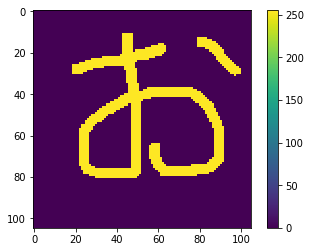

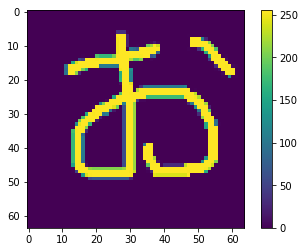

In [152]:
import cv2
small = np.clip(
    cv2.resize(original, dsize=(64, 64), interpolation=cv2.INTER_CUBIC),
    0.0, 255.0)
plt.figure()
im = plt.imshow(original)
plt.colorbar(im)

plt.figure()
im = plt.imshow(small)
plt.colorbar(im)

plt.show()

In [149]:
print(original.shape)

print(original.sum()/255.0)

(105, 105)
1558.0


Alphabet_of_the_Magi
Anglo-Saxon_Futhorc
Arcadian
Armenian
Asomtavruli_(Georgian)
Balinese
Bengali
Blackfoot_(Canadian_Aboriginal_Syllabics)
Braille
Burmese_(Myanmar)
Cyrillic
Early_Aramaic
Futurama
Grantha
Greek
Gujarati
Hebrew
Inuktitut_(Canadian_Aboriginal_Syllabics)
Japanese_(hiragana)
Japanese_(katakana)
Korean
Latin
Malay_(Jawi_-_Arabic)
Mkhedruli_(Georgian)
N_Ko
Ojibwe_(Canadian_Aboriginal_Syllabics)
Sanskrit
Syriac_(Estrangelo)
Tagalog
Tifinagh
('np.min(num_chars) ', 14)


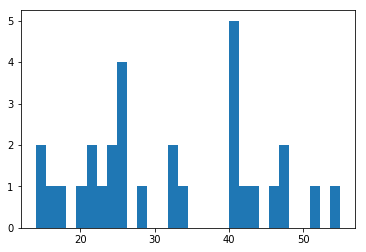

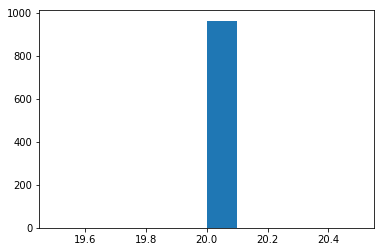

In [159]:
num_chars = []
samples_per_char = []
for a in sorted(alphas):
    print(a)
    num_chars.append(len(alphas[a]))
    for ch in alphas[a]:
        samples_per_char.append(len(alphas[a][ch]))

print("np.min(num_chars) ", np.min(num_chars))

plt.figure()
plt.hist(num_chars, bins=len(num_chars))

plt.figure()
plt.hist(samples_per_char)

plt.show()

Minimum number of characters in an alphabet is 14.

All characters in all alphabets have 20 samples.

In [3]:
print(original.shape, np.prod(original.shape))

((105, 105), 11025)


In [16]:
fcl = Focal(mute_output=True)


Loaded correlations from file


In [38]:
# print(fcl.kernels.full_kernels)

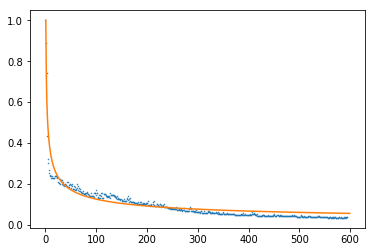

In [126]:
spikes = fcl.apply(original, spikes_per_unit=0.1)
arr_spk = np.array(spikes)
x = np.arange(600)
y = np.power(x, -0.45)


plt.figure()
# plt.loglog(arr_spk[:, 1], '.', markersize=1)
plt.plot(arr_spk[:, 1]/np.max(arr_spk[:, 1]), '.', markersize=1)
plt.plot(x, y)

plt.show()

In [6]:
# print(arr_spk[:, 1].tolist())

In [137]:
# ssa = focal_to_spike(spikes, original.shape,
#                      spikes_per_time_block=20, start_time=0., time_step=0.1)

In [166]:
fcl = Focal(mute_output=True)

data = np.load('omniglot/spikes_shrink/Alphabet_of_the_Magi/character01/sample_01.npz')
print(data.keys())
ssa = data['spike_source_array']
original = data['image']

Loaded correlations from file
['rank', 'spike_source_array', 'image']


In [167]:
# print(ssa)
len(ssa)

16384

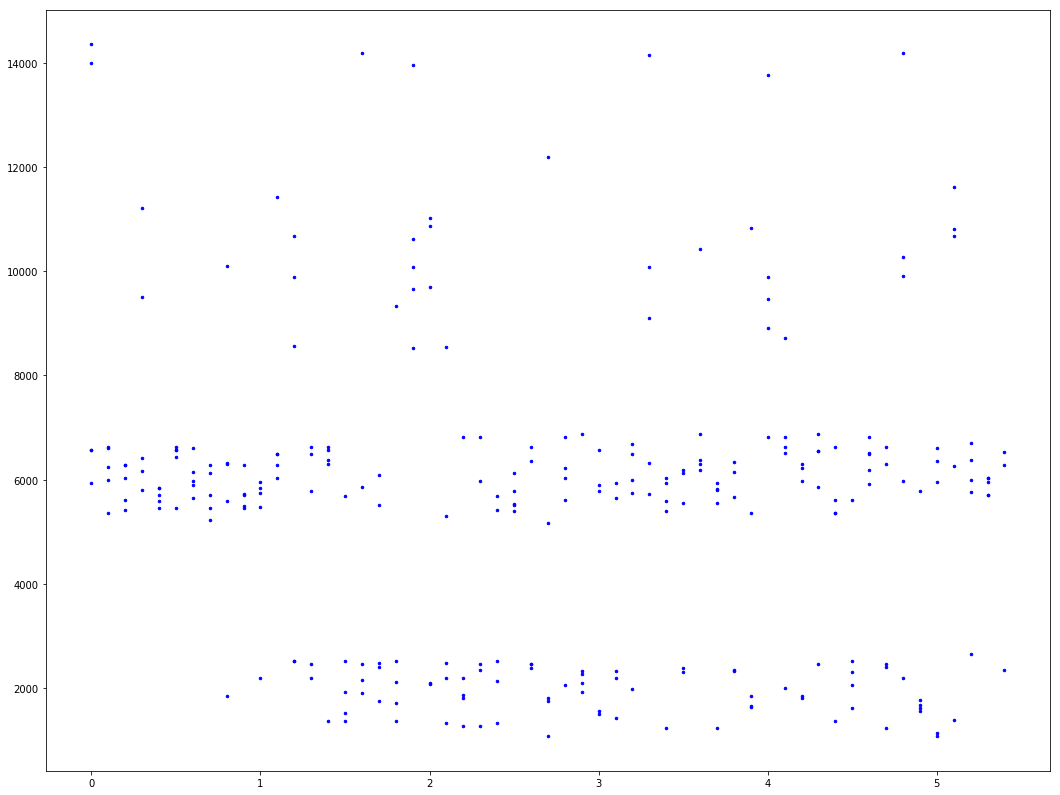

In [168]:
plt.figure(figsize=(18, 14))
for i, times in enumerate(ssa):
    if len(times):
        plt.plot(times, i*np.ones_like(times), '.b', markersize=5)
plt.show()

(0.0, 1.0)


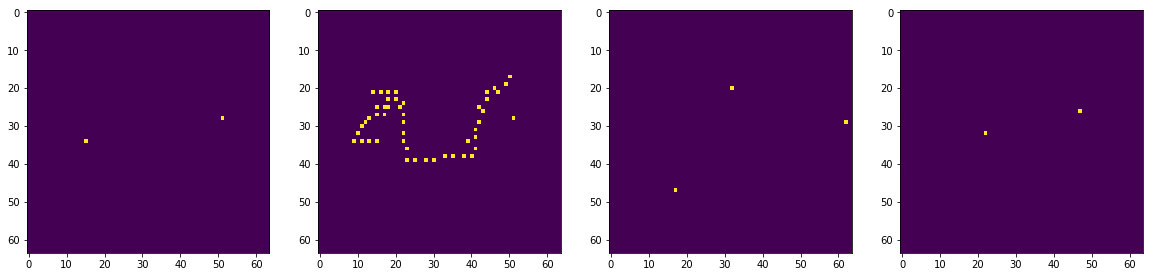

(1.0, 2.0)


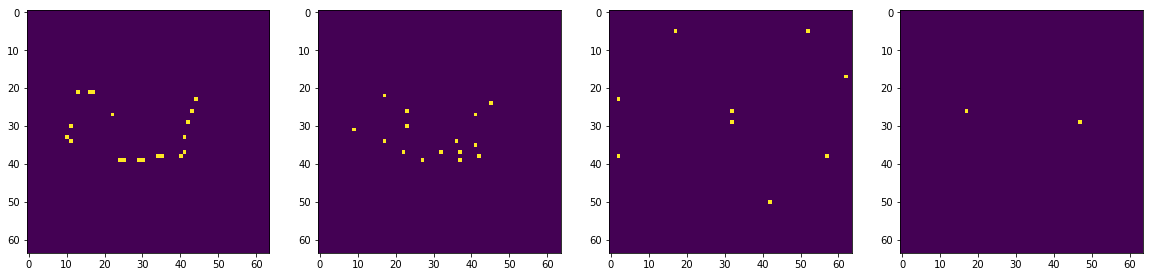

(2.0, 3.0)


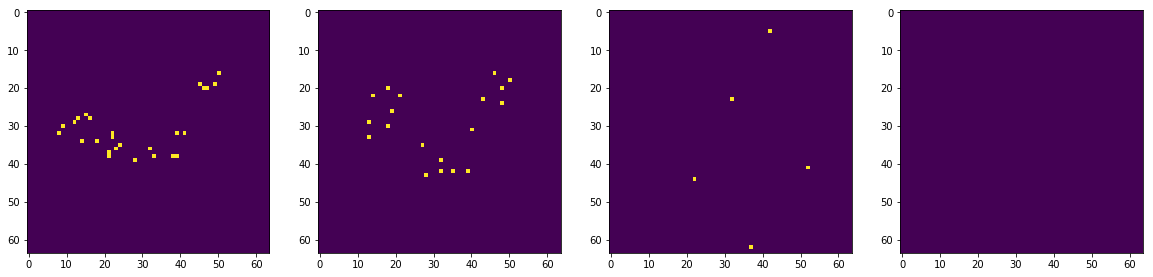

(3.0, 4.0)


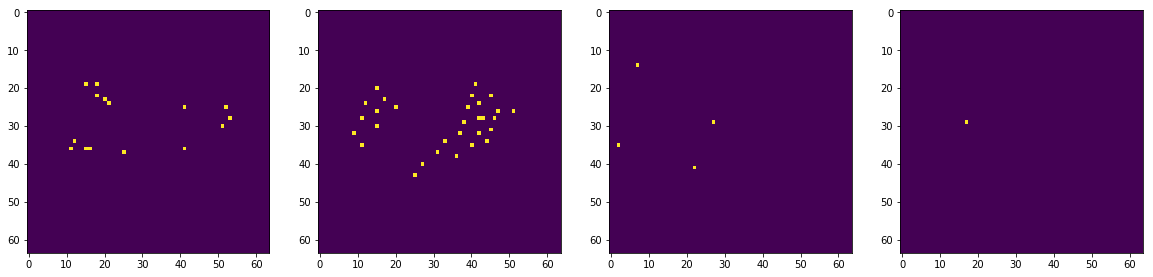

(4.0, 5.0)


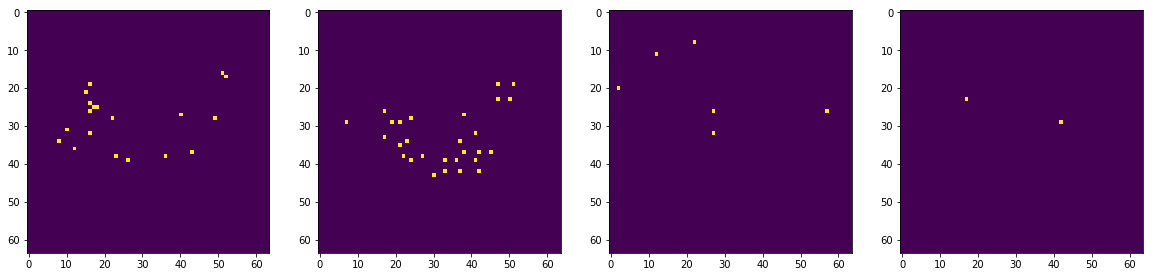

(5.0, 6.0)


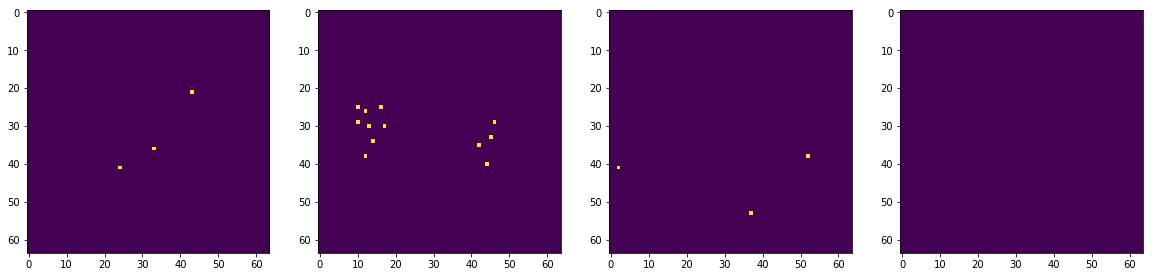

In [169]:
max_t = -1
for i, times in enumerate(ssa):
    if len(times):
        max_t = max(max_t, np.max(times))

max_t = np.ceil(max_t)
fw = 5.0
img_size = original.size
all_images = []
for st in np.arange(max_t):
    et = st + 1.0
    print(st, et)
    fig = plt.figure(figsize=(4*fw, fw))
    t_images = []
    for lyr in range(4):
        ax = plt.subplot(1, 4, lyr+1)
        img = np.zeros_like(original)
        for i, times in enumerate(ssa[lyr*img_size:(lyr+1)*img_size]):
            ts = np.array(times)
            whr = np.where(np.logical_and(st <= ts, ts < et))[0]
            if len(whr):
                r, c = i//original.shape[1], i%original.shape[1]
#                 if lyr > 1:
#                     r //= 3
#                     c //= 5
                img[r, c] += et**(-0.45) * 255.0
        t_images.append(img)

        plt.imshow(img.copy())

    all_images.append(t_images)
    plt.show()
    plt.close(fig)


In [176]:
cmap = 'bwr_r'
sums = [np.zeros_like(original) for _ in range(4)]
for imgs in all_images:
    for i, img in enumerate(imgs):
        sums[i] += img

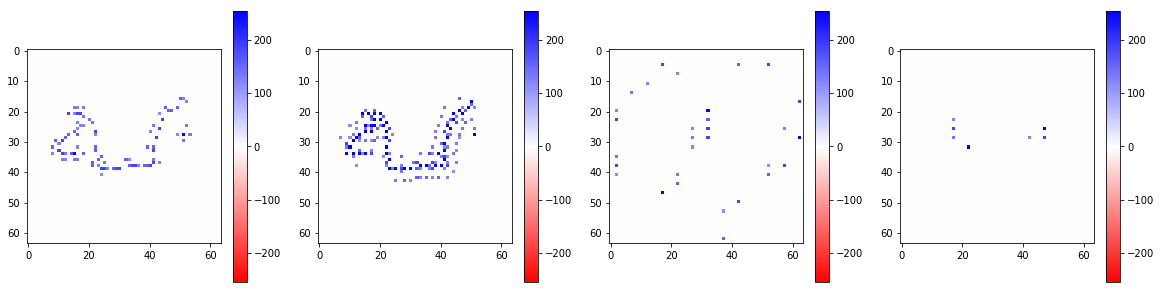

In [177]:
fig = plt.figure(figsize=(4*fw, fw))
for i, img in enumerate(sums):
    ax = plt.subplot(1, 4, i+1)
    im = plt.imshow(img, 
            cmap=cmap, 
            vmin=-np.max(np.abs(img)), 
            vmax=np.max(np.abs(img)),
            )
    plt.colorbar(im)
plt.show()

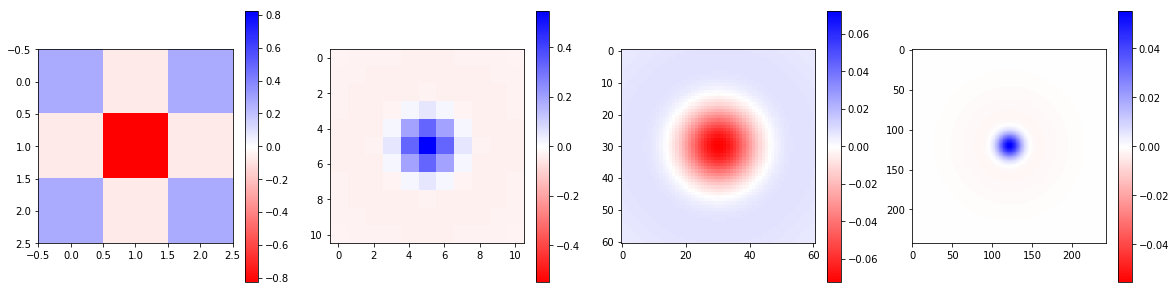

In [178]:
from scipy.signal import convolve2d
ks = fcl.kernels.full_kernels
fig = plt.figure(figsize=(4*fw, fw))
for i, img in ks.items():
    ax = plt.subplot(1, 4, i+1)
    im = plt.imshow(img,
            cmap=cmap, 
            vmin=-np.max(np.abs(img)), 
            vmax=np.max(np.abs(img)),
)
    plt.colorbar(im)
plt.show()

In [179]:
convs = [np.zeros_like(original) for _ in range(4)]
for i, k in ks.items():
    convs[i][:] = convolve2d(sums[i], k, mode='same')


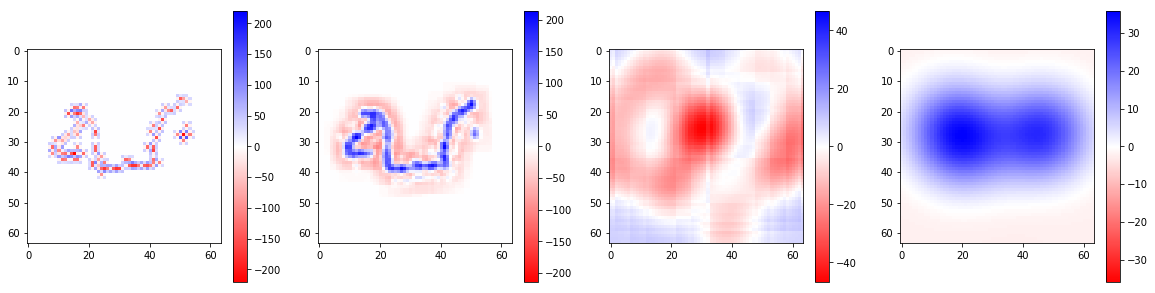

In [180]:
fig = plt.figure(figsize=(4*fw, fw))
for i, img in ks.items():
    ax = plt.subplot(1, 4, i+1)
    im = plt.imshow(convs[i],
            cmap=cmap, 
            vmin=-np.max(np.abs(convs[i])), 
            vmax=np.max(np.abs(convs[i])),)
    plt.colorbar(im)

plt.show()

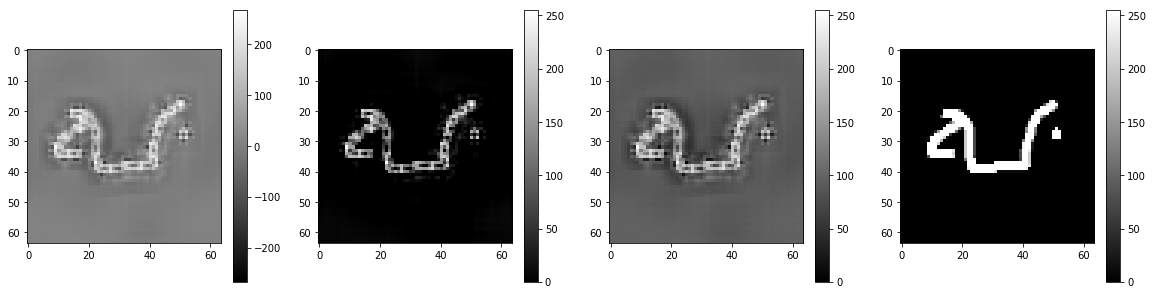

In [184]:
rec = np.zeros_like(original)
for c in convs:
    rec += c
img = np.clip(rec, 0.0, np.inf) if bool(0) else rec


plt.figure(figsize=(4*fw, fw))
ax = plt.subplot(1, 4, 1)
im = plt.imshow(img,
            cmap='gray', 
            vmin=-np.max(np.abs(img)), 
            vmax=np.max(np.abs(img)),)
plt.colorbar(im)

ax = plt.subplot(1, 4, 2)
im = plt.imshow(np.clip(img, 0, 255),
            cmap='gray', 
            vmin=0, 
            vmax=255,)
plt.colorbar(im)

ax = plt.subplot(1, 4, 3)
flat = img + np.abs(img.min())
flat *= (255.0 / flat.max())
im = plt.imshow(flat,
            cmap='gray', 
            vmin=0.0, 
            vmax=255.0,
            )
plt.colorbar(im)

ax = plt.subplot(1, 4, 4)
im = plt.imshow(original,
            cmap='gray', 
            vmin=0.0, 
            vmax=255.0,
            )
plt.colorbar(im)

plt.show()
# print(rec)

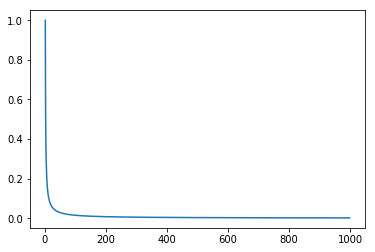

In [165]:
x = np.arange(1000)
y = np.power(x, -0.91)
plt.figure()
plt.plot(x, y)
plt.show()


In [113]:
3**-0.3


0.7192230933248643